## Imports

In [34]:
!python3 -m spacy download en
!python3 -m spacy download fr
!pip install torchinfo
!pip install einops
!pip install wandb

import math
import time
import os
import copy
import re
import torch
import torch.nn as nn
import torch.optim as optim
from torch import Tensor
from torch.nn import functional as F
from torch.optim.lr_scheduler import CosineAnnealingLR, StepLR
import torch.utils.checkpoint as cp
from torch.utils.data import DataLoader
from torch.jit.annotations import List
import torchvision
from torchvision import datasets, models, transforms
from torchvision.transforms import ToTensor, Normalize
from torchvision.transforms import Resize
from torchvision.transforms.functional_pil import resize
from torchvision.transforms import Grayscale
from torchvision.models.resnet import ResNet, BasicBlock
from torchvision.models.densenet import DenseNet
import matplotlib.pyplot as plt
import numpy as np
from collections import OrderedDict
from tqdm import tqdm
from torchinfo import summary
import wandb
from PIL import Image, ImageOps, ImageEnhance

2023-05-01 01:55:31.095937: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-05-01 01:55:33.409576: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
2023-05-01 01:55:36.835279: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-05-01 01:55:36.835935: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA n

**Drive**

In [3]:
from google.colab import drive
drive.mount('/content/gdrive')

baseline_path = "/content/gdrive/MyDrive/INF8225/project/baseline/"
MixUp_path = "/content/gdrive/MyDrive/INF8225/project/mixup/"
ManifoldMixUp_path = "/content/gdrive/MyDrive/INF8225/project/manifoldmixup/"
CutMix_path = "/content/gdrive/MyDrive/INF8225/project/cutmix/"
AugMix_path = "/content/gdrive/MyDrive/INF8225/project/augmix/"

Mounted at /content/gdrive


In [4]:
!wandb login

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit: 
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


In [35]:
seed = 5
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# **Downloading Data**

In [36]:
mnist_trainset = datasets.MNIST(root='./data/MNIST', train=True, download=True, transform=ToTensor())
mnist_testset = datasets.MNIST(root='./data/MNIST', train=False, download=True, transform=ToTensor())

CIFAR10_trainset = datasets.CIFAR10(root='./data/CIFAR', train=True, download=True, transform=ToTensor())
CIFAR10_testset = datasets.CIFAR10(root='./data/CIFAR', train=False, download=True, transform=ToTensor())

CIFAR100_trainset = datasets.CIFAR100(root='./data/CIFAR', train=True, download=True, transform=ToTensor())
CIFAR100_testset = datasets.CIFAR100(root='./data/CIFAR', train=False, download=True, transform=ToTensor())

print('MNIST:     train - ' + str(len(mnist_trainset)) + ' test - '+ str(len(mnist_testset)))
print('CIFAR-10:  train - ' + str(len(CIFAR10_trainset)) + ' test - '+ str(len(CIFAR10_testset)))
print('CIFAR-100: train - ' + str(len(CIFAR100_trainset)) + ' test - '+ str(len(CIFAR100_testset)))

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
MNIST:     train - 60000 test - 10000
CIFAR-10:  train - 50000 test - 10000
CIFAR-100: train - 50000 test - 10000


# **Displaying Data (Test)**

size: torch.Size([1, 28, 28])


<Figure size 640x480 with 0 Axes>

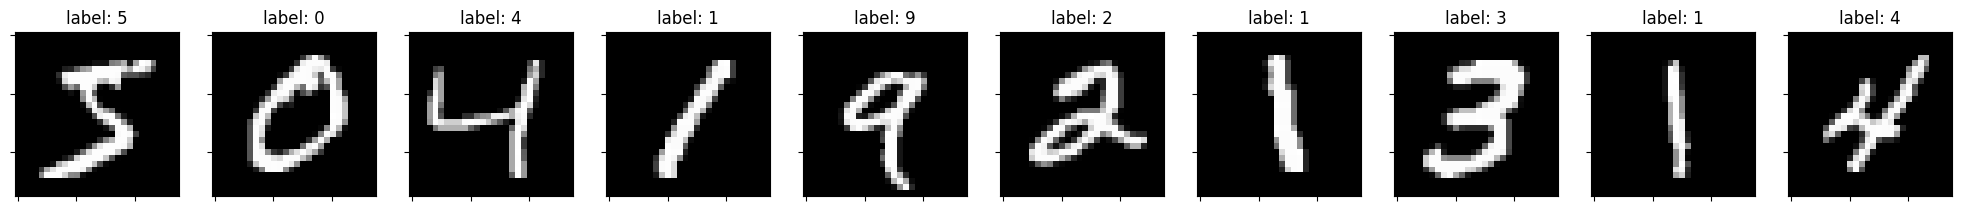

size: torch.Size([3, 32, 32])


<Figure size 640x480 with 0 Axes>

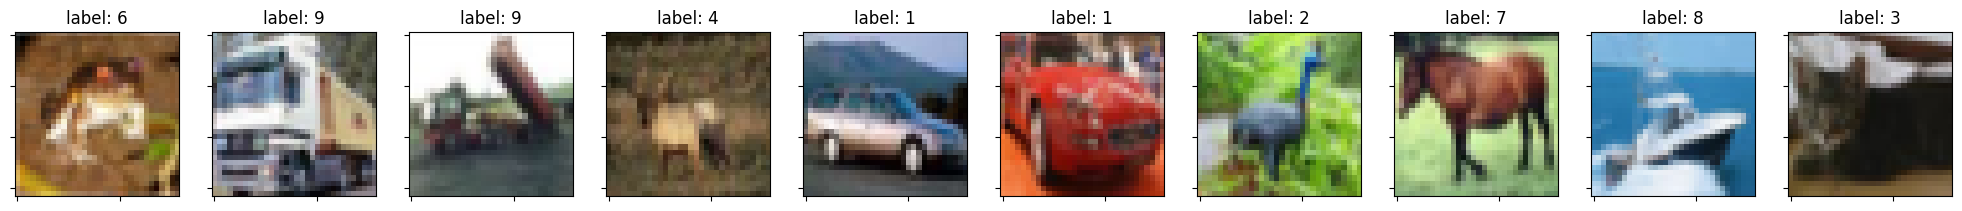

size: torch.Size([3, 32, 32])


<Figure size 640x480 with 0 Axes>

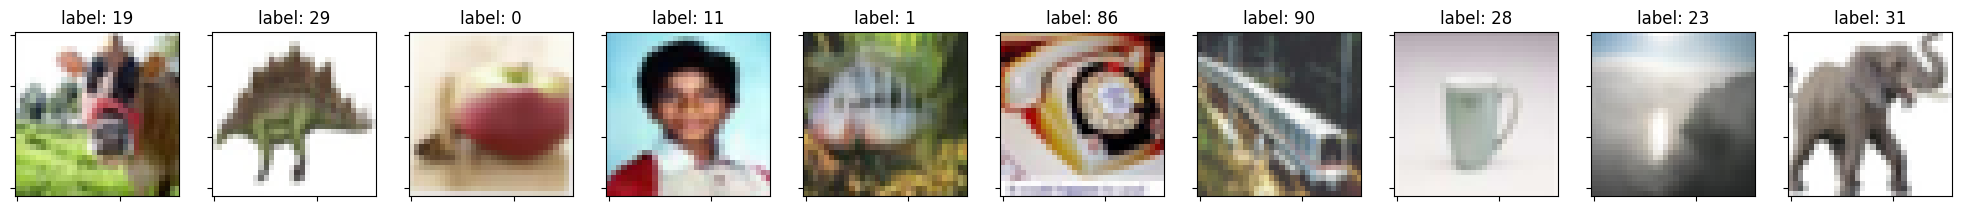

In [37]:
def imshow(dataset):
  print("size: " + str(dataset[0][0].shape))
  plt.figure()
  f,axs = plt.subplots(1,10,figsize=(25,25))
  if dataset in [mnist_trainset,mnist_testset]:
    for i in range(10):
      axs[i].imshow(dataset[i][0][0],cmap = 'gray')
      axs[i].set_title("label: " + str(dataset[i][1]))
  else:
    for i in range(10):
      axs[i].imshow((np.transpose(dataset[i][0],(1,2,0))))
      axs[i].set_title("label: " + str(dataset[i][1]))
  plt.setp([a.get_xticklabels() for a in axs[:]], visible=False)
  plt.setp([a.get_yticklabels() for a in axs[:]], visible=False)
  plt.show()
  

imshow(mnist_trainset)
imshow(CIFAR10_trainset)
imshow(CIFAR100_trainset)

# **Preprocessing Data**

In [38]:
mnist_trainset = datasets.MNIST(root='./data/MNIST', train=True, download=True)
mnist_trainset.transform = transforms.Compose([
               Grayscale(num_output_channels=3),
               ToTensor(),
               Normalize([0.1307],[0.3015]),
    ])
mnist_testset = datasets.MNIST(root='./data/MNIST', train=False, download=True)
mnist_testset.transform = transforms.Compose([
               Grayscale(num_output_channels=3),
               ToTensor(),
               Normalize([0.1307],[0.3015]),
    ])

CIFAR10_trainset = datasets.CIFAR10(root='./data/CIFAR', train=True, download=True)
CIFAR10_trainset.transform = transforms.Compose([
               transforms.RandomHorizontalFlip(),
               transforms.RandomCrop(32, padding=4),
               ToTensor(),
               Normalize([0.4914, 0.4822, 0.4465],[0.2023, 0.1994, 0.2010]),
    ])
CIFAR10_testset = datasets.CIFAR10(root='./data/CIFAR', train=False, download=True)
CIFAR10_testset.transform = transforms.Compose([
               ToTensor(),
               Normalize([0.4914, 0.4822, 0.4465],[0.2023, 0.1994, 0.2010]),
    ])

CIFAR100_trainset = datasets.CIFAR100(root='./data/CIFAR', train=True, download=True)
CIFAR100_trainset.transform = transforms.Compose([
               transforms.RandomHorizontalFlip(),
               transforms.RandomCrop(32, padding=4),
               ToTensor(),
               Normalize([0.5017, 0.4866, 0.4409],[0.2009, 0.1984, 0.2023]),
    ])
CIFAR100_testset = datasets.CIFAR100(root='./data/CIFAR', train=False, download=True)
CIFAR100_testset.transform = transforms.Compose([
               ToTensor(),
               Normalize([0.5017, 0.4866, 0.4409],[0.2009, 0.1984, 0.2023]),
    ])

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


# **Loading Data**

size: torch.Size([3, 28, 28])


<Figure size 640x480 with 0 Axes>

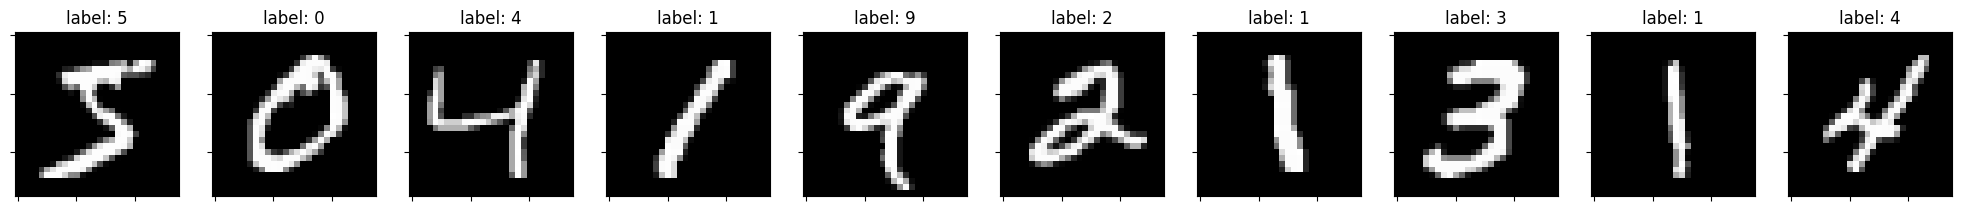

size: torch.Size([3, 32, 32])


<Figure size 640x480 with 0 Axes>

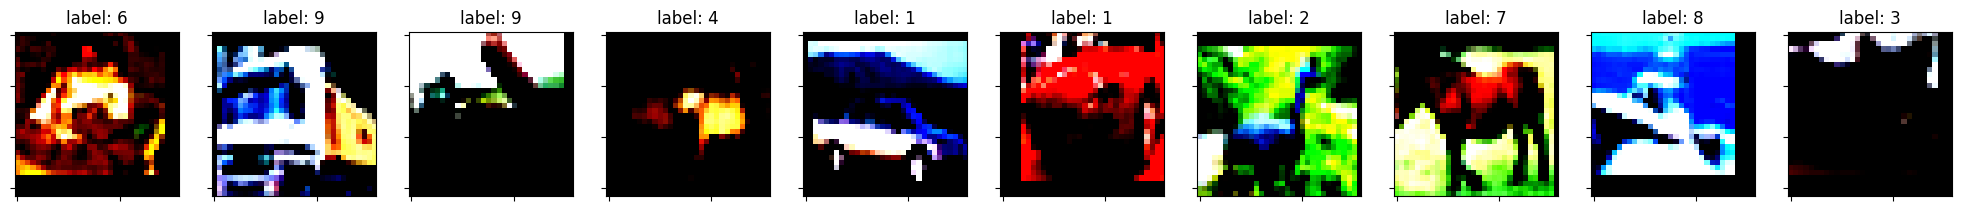

size: torch.Size([3, 32, 32])


<Figure size 640x480 with 0 Axes>

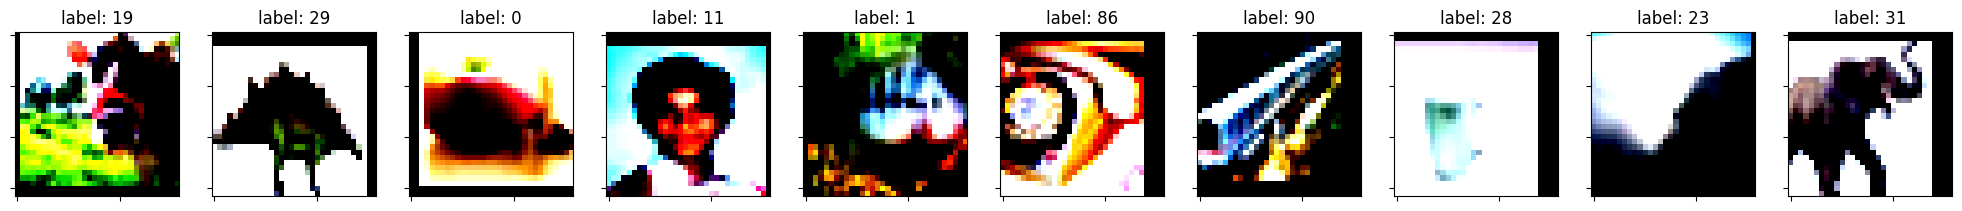

In [39]:
b_size = 128
mnist_trainloader = DataLoader(mnist_trainset, batch_size=b_size, shuffle=True)
mnist_testloader = DataLoader(mnist_testset, batch_size=b_size)
CIFAR10_trainloader = DataLoader(CIFAR10_trainset, batch_size=b_size, shuffle=True)
CIFAR10_testloader = DataLoader(CIFAR10_testset, batch_size=b_size)
CIFAR100_trainloader = DataLoader(CIFAR100_trainset, batch_size=b_size, shuffle=True)
CIFAR100_testloader = DataLoader(CIFAR100_testset, batch_size=b_size)

imshow(mnist_trainloader.dataset)
imshow(CIFAR10_trainloader.dataset)
imshow(CIFAR100_trainloader.dataset)

# **Base Network - ResNet-18**

In [40]:
class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_planes, planes, stride=1):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(
            in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3,
                               stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion*planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion*planes,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion*planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out


class Bottleneck(nn.Module):
    expansion = 4

    def __init__(self, in_planes, planes, stride=1):
        super(Bottleneck, self).__init__()
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3,
                               stride=stride, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)
        self.conv3 = nn.Conv2d(planes, self.expansion *
                               planes, kernel_size=1, bias=False)
        self.bn3 = nn.BatchNorm2d(self.expansion*planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion*planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion*planes,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion*planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = F.relu(self.bn2(self.conv2(out)))
        out = self.bn3(self.conv3(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out


class ResNet(nn.Module):
    def __init__(self, block, num_blocks, num_classes=10):
        super(ResNet, self).__init__()
        self.in_planes = 64

        self.conv1 = nn.Conv2d(3, 64, kernel_size=3,
                               stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.layer1 = self._make_layer(block, 64, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 128, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 256, num_blocks[2], stride=2)
        self.layer4 = self._make_layer(block, 512, num_blocks[3], stride=2)
        self.num_classes = num_classes
        self.linear = nn.Linear(512*block.expansion, self.num_classes)

    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1]*(num_blocks-1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride))
            self.in_planes = planes * block.expansion
        return nn.Sequential(*layers)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = F.avg_pool2d(out, 4)
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out


def ResNet18(num_classes):
    return ResNet(BasicBlock, [2, 2, 2, 2], num_classes)
     

# **Model Training**

In [ ]:
config = {
    'model_name' : 'resnet',
    'dataset_name' : 'CIFAR10',
    'batch_size' : 128,
    'lr': 1e-1,
    'weight_decay': 1e-4,
    'IMAGE_SIZE' : 32,
    'epochs' : 20,
    'num_classes' : 10,
    'feature_extract' : False,
    'log_every': 50,
    'mixup_alpha' : 1,
    'augmentations': True,
    'device': torch.device("cuda:0" if torch.cuda.is_available() else "cpu"),
    'DAmethod': 'Baseline'
}

device = config['device']

def adjust_learning_rate(optimizer, epoch):
    lr = config['lr']
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr

def train_model(model, trainloader, testloader, criterion, optimizer, scheduler, DAmethod, datasetname, num_epochs=25, jsd_loss = False):
  print('DAmethod - ', DAmethod)
  if DAmethod == "Baseline": savepath = baseline_path
  elif DAmethod == "MixUp": savepath = MixUp_path
  elif DAmethod == "ManifoldMixUp": savepath = ManifoldMixUp_path
  elif DAmethod == "CutMix": savepath = CutMix_path  
  elif DAmethod == "AugMix": savepath = AugMix_path

  since = time.time()
  val_acc_history = []

  best_model_wts = copy.deepcopy(model.state_dict())
  best_acc = 0.0

  earlystopping = 0.
  loss_ema = 0.

  device = config['device']

  for epoch in range(num_epochs):

    if earlystopping < 2000:

      print('Epoch {}/{}'.format(epoch+1, num_epochs))
      print('-' * 10)
      for phase in ['train', 'valid']:
        if phase == 'train':
          model.train()

          running_loss = 0.0
          running_corrects = 0

          for batch_idx,(inputs, labels) in tqdm(enumerate(trainloader)):
            optimizer.zero_grad()

            if jsd_loss:
              inputs_all = torch.cat(inputs,0).to(device)
              labels = labels.to(device)
              outputs_all = model(inputs_all)
              outputs_clean,outputs_aug1,outputs_aug2 = torch.split(
                  outputs_all, inputs[0].size(0)
              )
              _, preds = torch.max(outputs_clean, 1)

              loss = F.cross_entropy(outputs_clean,labels)

              p_clean = F.softmax(outputs_clean,dim=1)
              p_aug1 = F.softmax(outputs_aug1,dim=1)
              p_aug2 = F.softmax(outputs_aug2,dim=1)

              p_mixture = torch.clamp((p_clean+p_aug1+p_aug2)/3.,1e-7,1).log()

              loss += 12 * (F.kl_div(p_mixture, p_clean, reduction = 'batchmean') +
                       F.kl_div(p_mixture, p_aug1, reduction = 'batchmean') +
                       F.kl_div(p_mixture, p_aug2, reduction = 'batchmean')) / 3.

            elif DAmethod == 'MixUp':
              inputs = inputs.to(device)
              labels = labels.to(device) 
              inputs, labels, second_labels, lam = mixup(inputs, labels, config['mixup_alpha'])
              outputs = model(inputs)
              loss = mixup_criterion(criterion, outputs, labels, second_labels, lam)
              _, preds = torch.max(outputs, 1)
              
            elif DAmethod == 'CutMix':
              inputs = inputs.to(device)
              labels = labels.to(device) 
              inputs, labels, second_labels, lam = cutmix(inputs, labels, config['mixup_alpha'])
              outputs = model(inputs)
              loss = mixup_criterion(criterion, outputs, labels, second_labels, lam)
              _, preds = torch.max(outputs, 1)

            else:
              inputs = inputs.to(device)
              labels = labels.to(device) 
              outputs = model(inputs)
              loss = criterion(outputs, labels)
              _, preds = torch.max(outputs, 1)
            
            loss.backward()
            optimizer.step()
            

            if batch_idx % config['log_every'] == 0:
              if jsd_loss:
                train_logs = {
                    f'Train - jsd_loss': loss_ema
                }
                wandb.log(train_logs)
              else:
                train_logs = {
                    f'Train - loss': loss.item()
                }
                wandb.log(train_logs)


            if jsd_loss:
              loss_ema = loss_ema * 0.9 + float(loss) * 0.1
              running_loss += loss_ema * inputs[0].size(0)
            else:
              running_loss += loss.item() * inputs.size(0)

            running_corrects += torch.sum(preds == labels.data)

          epoch_loss = running_loss / len(trainloader.dataset)
          epoch_acc = running_corrects.double() / len(trainloader.dataset)
          print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))
          wandb.log({'Train - acc': epoch_acc})
        else:
          model.eval()

          running_loss = 0.0
          running_corrects = 0

          for inputs, labels in testloader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            optimizer.zero_grad()
            with torch.set_grad_enabled(False):
              outputs = model(inputs)
              loss = criterion(outputs, labels)

              _, preds = torch.max(outputs, 1)
              running_loss += loss.item() * inputs.size(0)
              running_corrects += torch.sum(preds == labels.data)
            epoch_loss = running_loss / len(testloader.dataset)
            epoch_acc = running_corrects.double() / len(testloader.dataset)
          wandb.log({'Valid - loss': epoch_loss})
          wandb.log({'Valid - acc': epoch_acc})

          print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))

          if epoch_acc > best_acc:
            best_acc = epoch_acc
            best_model_wts = copy.deepcopy(model.state_dict())

            checkpoint = {
                'epoch': epoch,
                'trainloader': trainloader,
                'testloader': testloader,
                'model': model,
                'state_dict': model.state_dict(),
                'best_acc': best_acc,
                'optimizer': optimizer.state_dict(),
                'scheduler': scheduler.state_dict(),
                }
            earlystopping = 0

            checkpoint_path = savepath + '{}_{}_checkpoint.pth.tar'.format(datasetname,DAmethod)
            print("Saving model...")
            torch.save(checkpoint, checkpoint_path)
          else:
            earlystopping += 1

          print('-' * 30 + '\n')
          val_acc_history.append(epoch_acc)

    if scheduler:
      scheduler.step()
    else:    
      adjust_learning_rate(optimizer, epoch)


  best_path = savepath + '{}_{}_best_model_{}.pth.tar'.format(datasetname, DAmethod, best_acc)
  torch.save(checkpoint, best_path)
  print("Best model saved.")
      
  time_elapsed = time.time() - since
  print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
  print('Best val Acc: {:4f}'.format(best_acc))
  model.load_state_dict(best_model_wts)
  return model, val_acc_history

def initialize_model(model_name, dataset_name, feature_extract=False, use_pretrained=False):
    model_ft = ResNet18(num_classes)
    input_size = 0

    if dataset_name == "mnist":
      input_size = 28
      num_classes = 10
    elif dataset_name =="cifar10":
      input_size = 32
      num_classes = 10
    else:
      input_size = 32
      num_classes = 100

    return model_ft, input_size

# **Training ResNet-18 on MNIST Dataset**

In [15]:
config['model_name'] = 'resnet'
config['dataset_name'] = 'mnist'

In [ ]:
model_ft, input_size = initialize_model(config['model_name'], config['dataset_name'])
optimizer_ft = optim.SGD(model_ft.parameters(), lr=config['lr'], momentum=0.9, weight_decay = 0.0005, nesterov = True)
scheduler_ft = CosineAnnealingLR(optimizer_ft, T_max = 60, eta_min = 1e-6 )
criterion = nn.CrossEntropyLoss()
model_ft = model_ft.to(device)

with wandb.init(
      config=config,
      project='INF8225 - Projet final',
      group= 'resnet18_mnist_Baseline',
      save_code=True,
  ):
  model_ft, hist = train_model(
      model_ft, mnist_trainloader,
      mnist_testloader, criterion,
      optimizer_ft, scheduler_ft,
      num_epochs=config['epochs']
      DAmethod= "Baseline",
      datasetname = config['dataset_name']
      )


W&B online. Running your script from this directory will now sync to the cloud.


Epoch 1/20
----------


469it [01:20,  5.85it/s]


train Loss: 0.4258 Acc: 0.8891
valid Loss: 0.1331 Acc: 0.9563
Saving model...
------------------------------

Epoch 2/20
----------


469it [01:21,  5.79it/s]


train Loss: 0.0507 Acc: 0.9849
valid Loss: 0.0479 Acc: 0.9859
Saving model...
------------------------------

Epoch 3/20
----------


469it [01:20,  5.83it/s]


train Loss: 0.0377 Acc: 0.9886
valid Loss: 0.0412 Acc: 0.9887
Saving model...
------------------------------

Epoch 4/20
----------


469it [01:21,  5.76it/s]


train Loss: 0.0310 Acc: 0.9905
valid Loss: 0.0728 Acc: 0.9762
------------------------------

Epoch 5/20
----------


469it [01:19,  5.88it/s]


train Loss: 0.0300 Acc: 0.9910
valid Loss: 0.0493 Acc: 0.9850
------------------------------

Epoch 6/20
----------


469it [01:19,  5.86it/s]


train Loss: 0.0272 Acc: 0.9921
valid Loss: 0.0564 Acc: 0.9820
------------------------------

Epoch 7/20
----------


469it [01:19,  5.90it/s]


train Loss: 0.0271 Acc: 0.9921
valid Loss: 0.0365 Acc: 0.9895
Saving model...
------------------------------

Epoch 8/20
----------


469it [01:19,  5.89it/s]


train Loss: 0.0249 Acc: 0.9927
valid Loss: 0.0332 Acc: 0.9904
Saving model...
------------------------------

Epoch 9/20
----------


469it [01:20,  5.84it/s]


train Loss: 0.0248 Acc: 0.9928
valid Loss: 0.0742 Acc: 0.9784
------------------------------

Epoch 10/20
----------


469it [01:19,  5.92it/s]


train Loss: 0.0244 Acc: 0.9928
valid Loss: 0.0396 Acc: 0.9886
------------------------------

Epoch 11/20
----------


469it [01:20,  5.82it/s]


train Loss: 0.0249 Acc: 0.9929
valid Loss: 0.0521 Acc: 0.9842
------------------------------

Epoch 12/20
----------


469it [01:19,  5.88it/s]


train Loss: 0.0206 Acc: 0.9944
valid Loss: 0.0812 Acc: 0.9764
------------------------------

Epoch 13/20
----------


469it [01:20,  5.81it/s]


train Loss: 0.0246 Acc: 0.9929
valid Loss: 0.0467 Acc: 0.9843
------------------------------

Epoch 14/20
----------


469it [01:21,  5.78it/s]


train Loss: 0.0225 Acc: 0.9938
valid Loss: 0.0255 Acc: 0.9924
Saving model...
------------------------------

Epoch 15/20
----------


469it [01:21,  5.73it/s]


train Loss: 0.0202 Acc: 0.9944
valid Loss: 0.0488 Acc: 0.9851
------------------------------

Epoch 16/20
----------


469it [01:20,  5.84it/s]


train Loss: 0.0196 Acc: 0.9947
valid Loss: 0.0348 Acc: 0.9895
------------------------------

Epoch 17/20
----------


469it [01:19,  5.92it/s]


train Loss: 0.0208 Acc: 0.9942
valid Loss: 0.0482 Acc: 0.9867
------------------------------

Epoch 18/20
----------


469it [01:20,  5.86it/s]


train Loss: 0.0213 Acc: 0.9941
valid Loss: 0.0318 Acc: 0.9904
------------------------------

Epoch 19/20
----------


469it [01:19,  5.92it/s]


train Loss: 0.0188 Acc: 0.9947
valid Loss: 0.0323 Acc: 0.9905
------------------------------

Epoch 20/20
----------


469it [01:22,  5.69it/s]


train Loss: 0.0172 Acc: 0.9952
valid Loss: 0.0342 Acc: 0.9903
------------------------------

Best model saved.
Training complete in 29m 8s
Best val Acc: 0.992400


Train - acc,▁▇██████████████████
Train - loss,█▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▁▁
Valid - acc,▁▇▇▅▇▆▇█▅▇▆▅▆█▇▇▇███
Valid - loss,█▂▂▄▃▃▂▂▄▂▃▅▂▁▃▂▂▁▁▂
Train - acc,0.99518
Train - loss,0.06733
Valid - acc,0.9903
Valid - loss,0.03421


# **Training ResNet-18 on CIFAR-10 Dataset**

In [ ]:
config['model_name'] = 'resnet'
config['dataset_name'] = 'cifar10'
model_ft, input_size = initialize_model(config['model_name'], config['dataset_name'])
optimizer = optim.SGD(model_ft.parameters(), lr=config['lr'], momentum=0.9, weight_decay = 0.0005, nesterov = True)
scheduler = CosineAnnealingLR(optimizer, T_max = 60, eta_min = 1e-6)
criterion = nn.CrossEntropyLoss()
model_ft = model_ft.to(device)

with wandb.init(
        config=config,
        project='INF8225 - Projet final',
        group= 'resnet18_cifar10',
        save_code=True,
    ):
  model_ft, hist = train_model(
      model_ft,
      CIFAR10_trainloader,
      CIFAR10_testloader,
      criterion,
      optimizer,
      scheduler,
      num_epochs=20,
      DAmethod = 'Baseline',
      datasetname = config['dataset_name']
      )


Epoch 1/20
----------


391it [01:18,  5.01it/s]


train Loss: 2.1176 Acc: 0.2510
valid Loss: 1.5989 Acc: 0.3988
Saving model...
------------------------------

Epoch 2/20
----------


391it [01:20,  4.83it/s]


train Loss: 1.5041 Acc: 0.4417
valid Loss: 1.3972 Acc: 0.4949
Saving model...
------------------------------

Epoch 3/20
----------


391it [01:19,  4.92it/s]


train Loss: 1.2085 Acc: 0.5633
valid Loss: 1.2703 Acc: 0.5588
Saving model...
------------------------------

Epoch 4/20
----------


391it [01:20,  4.88it/s]


train Loss: 0.9951 Acc: 0.6464
valid Loss: 0.9728 Acc: 0.6587
Saving model...
------------------------------

Epoch 5/20
----------


391it [01:15,  5.19it/s]


train Loss: 0.8673 Acc: 0.6937
valid Loss: 0.9901 Acc: 0.6569
------------------------------

Epoch 6/20
----------


391it [01:14,  5.24it/s]


train Loss: 0.7610 Acc: 0.7335
valid Loss: 0.8540 Acc: 0.7088
Saving model...
------------------------------

Epoch 7/20
----------


391it [01:15,  5.19it/s]


train Loss: 0.6725 Acc: 0.7664
valid Loss: 0.8672 Acc: 0.7106
Saving model...
------------------------------

Epoch 8/20
----------


391it [01:15,  5.19it/s]


train Loss: 0.6012 Acc: 0.7920
valid Loss: 0.6462 Acc: 0.7749
Saving model...
------------------------------

Epoch 9/20
----------


391it [01:15,  5.17it/s]


train Loss: 0.5600 Acc: 0.8047
valid Loss: 0.6662 Acc: 0.7811
Saving model...
------------------------------

Epoch 10/20
----------


391it [01:15,  5.20it/s]


train Loss: 0.5277 Acc: 0.8173
valid Loss: 0.6262 Acc: 0.7861
Saving model...
------------------------------

Epoch 11/20
----------


391it [01:16,  5.14it/s]


train Loss: 0.4979 Acc: 0.8290
valid Loss: 0.7637 Acc: 0.7436
------------------------------

Epoch 12/20
----------


391it [01:14,  5.25it/s]


train Loss: 0.4754 Acc: 0.8368
valid Loss: 0.5860 Acc: 0.7952
Saving model...
------------------------------

Epoch 13/20
----------


391it [01:15,  5.17it/s]


train Loss: 0.4526 Acc: 0.8455
valid Loss: 0.6008 Acc: 0.7938
------------------------------

Epoch 14/20
----------


391it [01:14,  5.25it/s]


train Loss: 0.4375 Acc: 0.8507
valid Loss: 0.7301 Acc: 0.7603
------------------------------

Epoch 15/20
----------


391it [01:14,  5.22it/s]


train Loss: 0.4186 Acc: 0.8560
valid Loss: 0.5669 Acc: 0.8133
Saving model...
------------------------------

Epoch 16/20
----------


391it [01:15,  5.18it/s]


train Loss: 0.4085 Acc: 0.8594
valid Loss: 0.6100 Acc: 0.8017
------------------------------

Epoch 17/20
----------


391it [01:14,  5.22it/s]


train Loss: 0.3839 Acc: 0.8693
valid Loss: 0.4862 Acc: 0.8389
Saving model...
------------------------------

Epoch 18/20
----------


391it [01:15,  5.18it/s]


train Loss: 0.3819 Acc: 0.8712
valid Loss: 0.5279 Acc: 0.8198
------------------------------

Epoch 19/20
----------


391it [01:15,  5.21it/s]


train Loss: 0.3661 Acc: 0.8745
valid Loss: 0.4565 Acc: 0.8480
Saving model...
------------------------------

Epoch 20/20
----------


391it [01:15,  5.19it/s]


train Loss: 0.3601 Acc: 0.8766
valid Loss: 0.6421 Acc: 0.7941
------------------------------

Best model saved.
Training complete in 28m 20s
Best val Acc: 0.848000


Train - acc,▁▃▄▅▆▆▇▇▇▇▇█████████
Train - loss,█▆▅▅▅▄▄▃▃▂▃▂▂▃▂▂▂▂▁▁▁▂▁▂▂▁▁▂▁▁▁▁▁▁▁▁▁▂▁▁
Valid - acc,▁▂▃▅▅▆▆▇▇▇▆▇▇▇▇▇███▇
Valid - loss,█▇▆▄▄▃▄▂▂▂▃▂▂▃▂▂▁▁▁▂
Train - acc,0.8766
Train - loss,0.3813
Valid - acc,0.7941
Valid - loss,0.64215


# **Training ResNet-18 on CIFAR-100 Dataset**

In [ ]:
config['dataset_name'] = 'cifar100'
config['model_name'] = 'resnet'

model_ft, input_size = initialize_model(config['model_name'], config['dataset_name'])
optimizer = optim.SGD(model_ft.parameters(), lr=config['lr'], momentum=0.9, weight_decay = 0.0005, nesterov = True)
scheduler = CosineAnnealingLR(optimizer, T_max = 60, eta_min = 1e-6)
criterion = nn.CrossEntropyLoss()
model_ft = model_ft.to(device)

with wandb.init(
        config=config,
        project='INF8225 - Projet final',
        group= 'resnet18_cifar100',
        save_code=True,
    ):
  model_ft, hist = train_model(
      model_ft,
      CIFAR100_trainloader,
      CIFAR100_testloader,
      criterion,
      optimizer,
      scheduler,
      num_epochs=config['epochs'],
      DAmethod = 'Baseline',
      datasetname = config['dataset_name'])

Epoch 1/20
----------


391it [01:16,  5.14it/s]


train Loss: 3.9346 Acc: 0.0951
valid Loss: 3.5503 Acc: 0.1460
Saving model...
------------------------------

Epoch 2/20
----------


391it [01:15,  5.16it/s]


train Loss: 3.2660 Acc: 0.1971
valid Loss: 3.2629 Acc: 0.2085
Saving model...
------------------------------

Epoch 3/20
----------


391it [01:16,  5.12it/s]


train Loss: 2.7849 Acc: 0.2850
valid Loss: 2.7142 Acc: 0.3139
Saving model...
------------------------------

Epoch 4/20
----------


391it [01:15,  5.17it/s]


train Loss: 2.3807 Acc: 0.3710
valid Loss: 2.4617 Acc: 0.3680
Saving model...
------------------------------

Epoch 5/20
----------


391it [01:15,  5.16it/s]


train Loss: 2.0965 Acc: 0.4340
valid Loss: 2.1853 Acc: 0.4199
Saving model...
------------------------------

Epoch 6/20
----------


391it [01:16,  5.14it/s]


train Loss: 1.8739 Acc: 0.4830
valid Loss: 1.9087 Acc: 0.4868
Saving model...
------------------------------

Epoch 7/20
----------


391it [01:15,  5.18it/s]


train Loss: 1.7239 Acc: 0.5189
valid Loss: 1.9497 Acc: 0.4790
------------------------------

Epoch 8/20
----------


391it [01:15,  5.20it/s]


train Loss: 1.6106 Acc: 0.5492
valid Loss: 1.8576 Acc: 0.4978
Saving model...
------------------------------

Epoch 9/20
----------


391it [01:15,  5.20it/s]


train Loss: 1.5209 Acc: 0.5694
valid Loss: 1.8622 Acc: 0.5008
Saving model...
------------------------------

Epoch 10/20
----------


391it [01:16,  5.14it/s]


train Loss: 1.4527 Acc: 0.5872
valid Loss: 1.6559 Acc: 0.5413
Saving model...
------------------------------

Epoch 11/20
----------


391it [01:15,  5.17it/s]


train Loss: 1.3809 Acc: 0.6047
valid Loss: 1.8639 Acc: 0.5173
------------------------------

Epoch 12/20
----------


391it [01:15,  5.21it/s]


train Loss: 1.3276 Acc: 0.6182
valid Loss: 1.7841 Acc: 0.5322
------------------------------

Epoch 13/20
----------


391it [01:14,  5.24it/s]


train Loss: 1.2831 Acc: 0.6285
valid Loss: 1.7513 Acc: 0.5342
------------------------------

Epoch 14/20
----------


391it [01:15,  5.18it/s]


train Loss: 1.2433 Acc: 0.6400
valid Loss: 1.7154 Acc: 0.5420
Saving model...
------------------------------

Epoch 15/20
----------


391it [01:15,  5.19it/s]


train Loss: 1.1956 Acc: 0.6527
valid Loss: 1.6126 Acc: 0.5662
Saving model...
------------------------------

Epoch 16/20
----------


391it [01:16,  5.10it/s]


train Loss: 1.1666 Acc: 0.6595
valid Loss: 1.5223 Acc: 0.5866
Saving model...
------------------------------

Epoch 17/20
----------


391it [01:15,  5.19it/s]


train Loss: 1.1294 Acc: 0.6721
valid Loss: 1.5479 Acc: 0.5764
------------------------------

Epoch 18/20
----------


391it [01:15,  5.16it/s]


train Loss: 1.1010 Acc: 0.6779
valid Loss: 1.5746 Acc: 0.5789
------------------------------

Epoch 19/20
----------


391it [01:16,  5.12it/s]


train Loss: 1.0561 Acc: 0.6911
valid Loss: 1.5528 Acc: 0.5873
Saving model...
------------------------------

Epoch 20/20
----------


391it [01:16,  5.14it/s]


train Loss: 1.0343 Acc: 0.6958
valid Loss: 1.5848 Acc: 0.5807
------------------------------

Best model saved.
Training complete in 28m 8s
Best val Acc: 0.587300


Train - acc,▁▂▃▄▅▆▆▆▇▇▇▇▇▇▇█████
Train - loss,█▇▆▅▅▅▄▄▃▃▃▃▃▃▂▃▂▂▂▂▁▂▂▂▁▂▂▁▁▂▁▁▁▂▁▁▁▁▁▁
Valid - acc,▁▂▄▅▅▆▆▇▇▇▇▇▇▇██████
Valid - loss,█▇▅▄▃▂▂▂▂▁▂▂▂▂▁▁▁▁▁▁
Train - acc,0.69578
Train - loss,1.06234
Valid - acc,0.5807
Valid - loss,1.58481


# **Mixup**

In [16]:
mnist_trainloader_small = DataLoader(mnist_trainset, batch_size=4, shuffle=True)
cif10_trainloader_small = DataLoader(CIFAR10_trainset, batch_size=4, shuffle=True)
cif100_trainloader_small = DataLoader(CIFAR100_trainset, batch_size=4, shuffle=True)

def mixup(inputs, labels, alpha):
  batch_size = inputs.size(0)
  shuffled_batch = torch.randperm(batch_size).to(config['device'])
  second_inputs = inputs[shuffled_batch]
  second_labels = labels[shuffled_batch]
  lam = np.random.beta(alpha, alpha)
  mixup_inputs = inputs * lam + second_inputs * (1 - lam)
  return mixup_inputs, labels, second_labels, lam

def mixup_criterion(criterion, output, original_labels, shuffled_labels, lam):
    return lam * criterion(output, original_labels) + (1 - lam) * criterion(output, shuffled_labels)


# **Training ResNet-18 + Mix Up on CIFAR-10 Dataset**

In [18]:
config['dataset_name'] = 'CIFAR10'
config['model_name'] =  'resnet'
config['DAmethod'] = 'MixUp'
model_ft, input_size = initialize_model(config['model_name'], config['dataset_name'] )

optimizer = optim.SGD(model_ft.parameters(), lr=config['lr'], momentum=0.9, weight_decay = config['weight_decay'], nesterov = True)
scheduler = CosineAnnealingLR(optimizer, T_max = 60, eta_min = 1e-6 )
criterion = nn.CrossEntropyLoss()
model_ft = model_ft.to(device)

with wandb.init(
    config=config,
    project='INF8225 - Projet final',
    save_code=True,
    group='resnet18_cifar10_mixup'):
  
  model_ft, hist = train_model(
      model_ft,
      CIFAR10_trainloader,
      CIFAR10_testloader,
      criterion,
      optimizer,
      DAmethod=config['DAmethod'],
      datasetname=config['dataset_name'],
      num_epochs=config['epochs'],
      scheduler=scheduler
      )


Start training CIFAR10 Model resnet
DAmethod -  MixUp
Epoch 1/20
----------


391it [01:12,  5.43it/s]


train Loss: 2.1605 Acc: 0.2108
valid Loss: 1.6430 Acc: 0.3898
Saving model...
------------------------------

Epoch 2/20
----------


391it [01:13,  5.34it/s]


train Loss: 1.8620 Acc: 0.2714
valid Loss: 1.5082 Acc: 0.4659
Saving model...
------------------------------

Epoch 3/20
----------


391it [01:14,  5.24it/s]


train Loss: 1.7640 Acc: 0.3096
valid Loss: 1.2853 Acc: 0.5532
Saving model...
------------------------------

Epoch 4/20
----------


391it [01:17,  5.07it/s]


train Loss: 1.6679 Acc: 0.3163
valid Loss: 1.2231 Acc: 0.5729
Saving model...
------------------------------

Epoch 5/20
----------


391it [01:19,  4.92it/s]


train Loss: 1.5968 Acc: 0.3631
valid Loss: 1.1508 Acc: 0.6047
Saving model...
------------------------------

Epoch 6/20
----------


391it [01:19,  4.94it/s]


train Loss: 1.5335 Acc: 0.3917
valid Loss: 1.0122 Acc: 0.6649
Saving model...
------------------------------

Epoch 7/20
----------


391it [01:17,  5.05it/s]


train Loss: 1.4849 Acc: 0.3913
valid Loss: 0.9577 Acc: 0.6978
Saving model...
------------------------------

Epoch 8/20
----------


391it [01:18,  4.97it/s]


train Loss: 1.4266 Acc: 0.3981
valid Loss: 0.9552 Acc: 0.6859
------------------------------

Epoch 9/20
----------


391it [01:16,  5.11it/s]


train Loss: 1.4086 Acc: 0.3940
valid Loss: 0.9202 Acc: 0.7066
Saving model...
------------------------------

Epoch 10/20
----------


391it [01:15,  5.16it/s]


train Loss: 1.3689 Acc: 0.4250
valid Loss: 0.8363 Acc: 0.7448
Saving model...
------------------------------

Epoch 11/20
----------


391it [01:15,  5.15it/s]


train Loss: 1.3416 Acc: 0.4288
valid Loss: 0.7847 Acc: 0.7528
Saving model...
------------------------------

Epoch 12/20
----------


391it [01:13,  5.33it/s]


train Loss: 1.3036 Acc: 0.4290
valid Loss: 0.7640 Acc: 0.7545
Saving model...
------------------------------

Epoch 13/20
----------


391it [01:14,  5.26it/s]


train Loss: 1.2763 Acc: 0.4400
valid Loss: 0.6518 Acc: 0.8074
Saving model...
------------------------------

Epoch 14/20
----------


391it [01:13,  5.32it/s]


train Loss: 1.2600 Acc: 0.4529
valid Loss: 0.6932 Acc: 0.8071
------------------------------

Epoch 15/20
----------


391it [01:13,  5.29it/s]


train Loss: 1.2405 Acc: 0.4403
valid Loss: 0.6233 Acc: 0.8299
Saving model...
------------------------------

Epoch 16/20
----------


391it [01:13,  5.29it/s]


train Loss: 1.2256 Acc: 0.4471
valid Loss: 0.6724 Acc: 0.8154
------------------------------

Epoch 17/20
----------


391it [01:12,  5.36it/s]


train Loss: 1.1938 Acc: 0.4756
valid Loss: 0.6912 Acc: 0.8031
------------------------------

Epoch 18/20
----------


391it [01:12,  5.39it/s]


train Loss: 1.1980 Acc: 0.4567
valid Loss: 0.5803 Acc: 0.8484
Saving model...
------------------------------

Epoch 19/20
----------


391it [01:13,  5.29it/s]


train Loss: 1.1743 Acc: 0.4747
valid Loss: 0.6101 Acc: 0.8412
------------------------------

Epoch 20/20
----------


391it [01:12,  5.41it/s]


train Loss: 1.1545 Acc: 0.4700
valid Loss: 0.5347 Acc: 0.8523
Saving model...
------------------------------

Best model saved.
Training complete in 28m 15s
Best val Acc: 0.852300


Train - acc,▁▃▄▄▅▆▆▆▆▇▇▇▇▇▇▇█▇██
Train - loss,█▇▇▇▆▅▅▇▅▆▆▃▆▂▄▇▄▄▂▅▆▄▆▅▁▅▅▃▄▂▅▅▆▄▂▅▃▅▃▄
Valid - acc,▁▂▃▄▄▅▆▅▆▆▆▇▇▇█▇▇███
Valid - loss,█▇▆▅▅▄▄▄▃▃▃▂▂▂▂▂▂▁▁▁
Train - acc,0.46996
Train - loss,1.37486
Valid - acc,0.8523
Valid - loss,0.53468


# **Training ResNet-18 + Mix Up on CIFAR-100 Dataset**

In [17]:
config['dataset_name'] = 'CIFAR100'
config['model_name'] =  'resnet'
config['DAmethod'] = 'MixUp'
model_ft, input_size = initialize_model(config['model_name'], config['dataset_name'] )
optimizer = optim.SGD(model_ft.parameters(), lr=config['lr'], momentum=0.9, weight_decay = config['weight_decay'], nesterov = True)
scheduler = CosineAnnealingLR(optimizer, T_max = 60, eta_min = 1e-6 )
criterion = nn.CrossEntropyLoss()
model_ft = model_ft.to(device)

with wandb.init(
    config=config,
    project='INF8225 - Projet final',
    save_code=True,
    group='resnet18_cifar10_mixup'):
  
    model_ft, hist = train_model(
      model_ft,
      CIFAR100_trainloader,
      CIFAR100_testloader,
      criterion,
      optimizer,
      DAmethod=config['DAmethod'],
      datasetname=config['dataset_name'],
      num_epochs=config['epochs'],
      scheduler=scheduler
      )


     

wandb: Currently logged in as: ahashanragib (ahashan). Use `wandb login --relogin` to force relogin


Start training CIFAR100 Model resnet
DAmethod -  MixUp
Epoch 1/20
----------


391it [01:18,  5.00it/s]


train Loss: 4.2162 Acc: 0.0497
valid Loss: 3.7359 Acc: 0.1133
Saving model...
------------------------------

Epoch 2/20
----------


391it [01:12,  5.40it/s]


train Loss: 3.8472 Acc: 0.0882
valid Loss: 3.2473 Acc: 0.2141
Saving model...
------------------------------

Epoch 3/20
----------


391it [01:12,  5.40it/s]


train Loss: 3.6189 Acc: 0.1203
valid Loss: 2.8666 Acc: 0.2811
Saving model...
------------------------------

Epoch 4/20
----------


391it [02:38,  2.47it/s]


train Loss: 3.3889 Acc: 0.1629
valid Loss: 2.5949 Acc: 0.3425
Saving model...
------------------------------

Epoch 5/20
----------


391it [02:33,  2.55it/s]


train Loss: 3.2385 Acc: 0.1689
valid Loss: 2.3684 Acc: 0.3897
Saving model...
------------------------------

Epoch 6/20
----------


391it [02:32,  2.57it/s]


train Loss: 3.1117 Acc: 0.1991
valid Loss: 2.2464 Acc: 0.4322
Saving model...
------------------------------

Epoch 7/20
----------


391it [02:33,  2.54it/s]


train Loss: 2.9080 Acc: 0.2361
valid Loss: 2.0354 Acc: 0.4669
Saving model...
------------------------------

Epoch 8/20
----------


391it [02:33,  2.55it/s]


train Loss: 2.8172 Acc: 0.2401
valid Loss: 1.9042 Acc: 0.5081
Saving model...
------------------------------

Epoch 9/20
----------


391it [02:39,  2.45it/s]


train Loss: 2.8483 Acc: 0.2712
valid Loss: 2.0488 Acc: 0.4836
------------------------------

Epoch 10/20
----------


391it [02:35,  2.51it/s]


train Loss: 2.7310 Acc: 0.2574
valid Loss: 1.8157 Acc: 0.5361
Saving model...
------------------------------

Epoch 11/20
----------


391it [02:32,  2.57it/s]


train Loss: 2.6530 Acc: 0.2710
valid Loss: 1.8156 Acc: 0.5327
------------------------------

Epoch 12/20
----------


391it [01:41,  3.85it/s]


train Loss: 2.5892 Acc: 0.2982
valid Loss: 1.6706 Acc: 0.5717
Saving model...
------------------------------

Epoch 13/20
----------


391it [01:12,  5.39it/s]


train Loss: 2.6179 Acc: 0.2754
valid Loss: 1.6527 Acc: 0.5820
Saving model...
------------------------------

Epoch 14/20
----------


391it [01:13,  5.35it/s]


train Loss: 2.5419 Acc: 0.3057
valid Loss: 1.6081 Acc: 0.5823
Saving model...
------------------------------

Epoch 15/20
----------


391it [01:12,  5.37it/s]


train Loss: 2.5203 Acc: 0.3031
valid Loss: 1.7583 Acc: 0.5682
------------------------------

Epoch 16/20
----------


391it [01:16,  5.13it/s]


train Loss: 2.3926 Acc: 0.3214
valid Loss: 1.5189 Acc: 0.6186
Saving model...
------------------------------

Epoch 17/20
----------


391it [01:13,  5.30it/s]


train Loss: 2.4362 Acc: 0.3087
valid Loss: 1.4480 Acc: 0.6288
Saving model...
------------------------------

Epoch 18/20
----------


391it [01:13,  5.31it/s]


train Loss: 2.4046 Acc: 0.2999
valid Loss: 1.5308 Acc: 0.6114
------------------------------

Epoch 19/20
----------


391it [01:12,  5.40it/s]


train Loss: 2.3269 Acc: 0.3201
valid Loss: 1.3136 Acc: 0.6475
Saving model...
------------------------------

Epoch 20/20
----------


391it [01:12,  5.38it/s]


train Loss: 2.3032 Acc: 0.3164
valid Loss: 1.3353 Acc: 0.6497
Saving model...
------------------------------

Best model saved.
Training complete in 39m 17s
Best val Acc: 0.649700


Train - acc,▁▂▃▄▄▅▆▆▇▆▇▇▇████▇██
Train - loss,█▇▇▆▆▇▇▅▇▄▅▆▆▄▆▆▄▄▅▆▅▂▂▅▅▅▅▄▅▄▂▅▂▅▅▁▃▅▃▆
Valid - acc,▁▂▃▄▅▅▆▆▆▇▆▇▇▇▇█████
Valid - loss,█▇▅▅▄▄▃▃▃▂▂▂▂▂▂▂▁▂▁▁
Train - acc,0.3164
Train - loss,3.25535
Valid - acc,0.6497
Valid - loss,1.3353


# **Cut Mix**

In [19]:
def cutmix(inputs, labels, alpha):
  batch_size = inputs.size(0)
  shuffled_batch = torch.randperm(batch_size).to(config['device'])
  second_inputs = inputs[shuffled_batch]
  second_labels = labels[shuffled_batch]
  lam = np.random.beta(alpha, alpha)
  
  mixup_inputs = torch.clone(inputs)
  W = mixup_inputs.size(2)
  H = mixup_inputs.size(3)

  for i in range(batch_size):
    height = int(W*np.sqrt(1-lam)) 
    width = int(H*np.sqrt(1-lam))
    randx = np.random.randint(0,W-width)
    randy = np.random.randint(0,H-height)

    mixup_inputs[i,:,randy:randy + height,randx:randx + width] = second_inputs[i,:,randy:randy + height,randx:randx + width]

  return mixup_inputs, labels, second_labels, lam

def mixup_criterion(criterion, output, original_labels, shuffled_labels, lam):
    return lam * criterion(output, original_labels) + (1 - lam) * criterion(output, shuffled_labels)

# **Training ResNet-18 + CutMix on CIFAR-10 Dataset**

In [20]:
config['dataset_name'] = 'CIFAR10'
config['model_name'] =  'resnet'
config['DAmethod'] = 'CutMix'
model_ft, input_size = initialize_model('resnet', 'CIFAR10')
optimizer = optim.SGD(model_ft.parameters(), lr=config['lr'], momentum=0.9, weight_decay = config['weight_decay'], nesterov = True)
scheduler = CosineAnnealingLR(optimizer, T_max = 60, eta_min = 1e-6 )
criterion = nn.CrossEntropyLoss()
model_ft = model_ft.to(device)

with wandb.init(
    config=config,
    project='INF8225 - Projet final',
    save_code=True,
    group='resnet18_cifar10_mixup'):
  model_ft, hist = train_model(
      model_ft,
      CIFAR10_trainloader,
      CIFAR10_testloader,
      criterion,
      optimizer,
      DAmethod=config['DAmethod'],
      datasetname=config['dataset_name'],
      num_epochs=config['epochs'],
      scheduler=scheduler
      )

Start training CIFAR10 Model resnet
DAmethod -  CutMix
Epoch 1/20
----------


391it [01:13,  5.31it/s]


train Loss: 2.4670 Acc: 0.1539
valid Loss: 1.8455 Acc: 0.3268
Saving model...
------------------------------

Epoch 2/20
----------


391it [01:16,  5.09it/s]


train Loss: 1.9929 Acc: 0.2095
valid Loss: 1.6190 Acc: 0.3996
Saving model...
------------------------------

Epoch 3/20
----------


391it [01:16,  5.13it/s]


train Loss: 1.9076 Acc: 0.2253
valid Loss: 1.4876 Acc: 0.4595
Saving model...
------------------------------

Epoch 4/20
----------


391it [01:17,  5.07it/s]


train Loss: 1.8328 Acc: 0.2479
valid Loss: 1.3127 Acc: 0.5290
Saving model...
------------------------------

Epoch 5/20
----------


391it [01:16,  5.09it/s]


train Loss: 1.7636 Acc: 0.2749
valid Loss: 1.2818 Acc: 0.5502
Saving model...
------------------------------

Epoch 6/20
----------


391it [01:17,  5.03it/s]


train Loss: 1.6824 Acc: 0.2987
valid Loss: 1.1685 Acc: 0.5906
Saving model...
------------------------------

Epoch 7/20
----------


391it [01:16,  5.11it/s]


train Loss: 1.6023 Acc: 0.2938
valid Loss: 1.0682 Acc: 0.6325
Saving model...
------------------------------

Epoch 8/20
----------


391it [01:16,  5.08it/s]


train Loss: 1.5805 Acc: 0.3040
valid Loss: 1.0240 Acc: 0.6635
Saving model...
------------------------------

Epoch 9/20
----------


391it [01:16,  5.09it/s]


train Loss: 1.5405 Acc: 0.3280
valid Loss: 1.0922 Acc: 0.6293
------------------------------

Epoch 10/20
----------


391it [01:16,  5.11it/s]


train Loss: 1.4981 Acc: 0.3363
valid Loss: 0.8989 Acc: 0.7093
Saving model...
------------------------------

Epoch 11/20
----------


391it [01:16,  5.14it/s]


train Loss: 1.4564 Acc: 0.3403
valid Loss: 0.8770 Acc: 0.7138
Saving model...
------------------------------

Epoch 12/20
----------


391it [01:16,  5.13it/s]


train Loss: 1.4240 Acc: 0.3416
valid Loss: 0.8322 Acc: 0.7258
Saving model...
------------------------------

Epoch 13/20
----------


391it [01:18,  4.97it/s]


train Loss: 1.3665 Acc: 0.3754
valid Loss: 0.7449 Acc: 0.7496
Saving model...
------------------------------

Epoch 14/20
----------


391it [01:16,  5.13it/s]


train Loss: 1.3392 Acc: 0.3478
valid Loss: 0.7140 Acc: 0.7702
Saving model...
------------------------------

Epoch 15/20
----------


391it [01:17,  5.08it/s]


train Loss: 1.3087 Acc: 0.3798
valid Loss: 0.7464 Acc: 0.7693
------------------------------

Epoch 16/20
----------


391it [01:15,  5.19it/s]


train Loss: 1.2917 Acc: 0.3653
valid Loss: 0.6609 Acc: 0.7956
Saving model...
------------------------------

Epoch 17/20
----------


391it [01:17,  5.05it/s]


train Loss: 1.2718 Acc: 0.4065
valid Loss: 0.6733 Acc: 0.7856
------------------------------

Epoch 18/20
----------


391it [01:15,  5.18it/s]


train Loss: 1.2719 Acc: 0.4048
valid Loss: 0.5778 Acc: 0.8321
Saving model...
------------------------------

Epoch 19/20
----------


391it [01:16,  5.08it/s]


train Loss: 1.2402 Acc: 0.3795
valid Loss: 0.6256 Acc: 0.8206
------------------------------

Epoch 20/20
----------


391it [01:15,  5.21it/s]


train Loss: 1.2529 Acc: 0.3833
valid Loss: 0.6087 Acc: 0.8336
Saving model...
------------------------------

Best model saved.
Training complete in 28m 44s
Best val Acc: 0.833600


Train - acc,▁▃▃▄▄▅▅▅▆▆▆▆▇▆▇▇██▇▇
Train - loss,███▅▅▅▇▅▅▆▆▅▂▅▃▂▃▃▄▄▄▂▄▁▄▄▁▄▅▅▃▃▃▄▄▄▄▄▄▃
Valid - acc,▁▂▃▄▄▅▅▆▅▆▆▇▇▇▇▇▇███
Valid - loss,█▇▆▅▅▄▄▃▄▃▃▂▂▂▂▁▂▁▁▁
Train - acc,0.38326
Train - loss,1.24722
Valid - acc,0.8336
Valid - loss,0.6087


# **Training ResNet-18 + CutMix on CIFAR-100 Dataset**

In [21]:
config['dataset_name'] = 'CIFAR100'
config['model_name'] =  'resnet'
config['DAmethod'] = 'CutMix'
model_ft, input_size = initialize_model('resnet', 'CIFAR100')
optimizer = optim.SGD(model_ft.parameters(), lr=config['lr'], momentum=0.9, weight_decay = config['weight_decay'], nesterov = True)
scheduler = CosineAnnealingLR(optimizer, T_max = 60, eta_min = 1e-6 )
criterion = nn.CrossEntropyLoss()
model_ft = model_ft.to(device)

with wandb.init(config=config, project='INF8225 - Projet final', save_code=True, group='resnet18_cifar10_mixup'):
  model_ft, hist = train_model(
      model_ft,
      CIFAR100_trainloader,
      CIFAR100_testloader,
      criterion,
      optimizer,
      DAmethod=config['DAmethod'],
      datasetname=config['dataset_name'],
      num_epochs=config['epochs'],
      scheduler=scheduler
      )

Start training CIFAR100 Model resnet
DAmethod -  CutMix
Epoch 1/20
----------


391it [01:14,  5.23it/s]


train Loss: 4.2861 Acc: 0.0390
valid Loss: 3.8270 Acc: 0.1043
Saving model...
------------------------------

Epoch 2/20
----------


391it [01:16,  5.10it/s]


train Loss: 3.9913 Acc: 0.0631
valid Loss: 3.3604 Acc: 0.1850
Saving model...
------------------------------

Epoch 3/20
----------


391it [01:16,  5.13it/s]


train Loss: 3.7724 Acc: 0.0823
valid Loss: 3.1173 Acc: 0.2329
Saving model...
------------------------------

Epoch 4/20
----------


391it [01:16,  5.10it/s]


train Loss: 3.5892 Acc: 0.1112
valid Loss: 2.7771 Acc: 0.3019
Saving model...
------------------------------

Epoch 5/20
----------


391it [01:16,  5.14it/s]


train Loss: 3.3702 Acc: 0.1124
valid Loss: 2.6304 Acc: 0.3323
Saving model...
------------------------------

Epoch 6/20
----------


391it [01:16,  5.09it/s]


train Loss: 3.2183 Acc: 0.1413
valid Loss: 2.2195 Acc: 0.4132
Saving model...
------------------------------

Epoch 7/20
----------


391it [01:16,  5.10it/s]


train Loss: 3.1545 Acc: 0.1618
valid Loss: 2.1338 Acc: 0.4322
Saving model...
------------------------------

Epoch 8/20
----------


391it [01:16,  5.09it/s]


train Loss: 2.9857 Acc: 0.1703
valid Loss: 2.1872 Acc: 0.4247
------------------------------

Epoch 9/20
----------


391it [01:15,  5.18it/s]


train Loss: 2.9192 Acc: 0.1741
valid Loss: 1.9479 Acc: 0.4884
Saving model...
------------------------------

Epoch 10/20
----------


391it [01:17,  5.06it/s]


train Loss: 2.8343 Acc: 0.1855
valid Loss: 1.9697 Acc: 0.4854
------------------------------

Epoch 11/20
----------


391it [01:16,  5.13it/s]


train Loss: 2.7507 Acc: 0.2088
valid Loss: 1.7000 Acc: 0.5452
Saving model...
------------------------------

Epoch 12/20
----------


391it [01:16,  5.12it/s]


train Loss: 2.6821 Acc: 0.2118
valid Loss: 1.7263 Acc: 0.5423
------------------------------

Epoch 13/20
----------


391it [01:16,  5.09it/s]


train Loss: 2.6834 Acc: 0.2303
valid Loss: 1.7326 Acc: 0.5430
------------------------------

Epoch 14/20
----------


391it [01:15,  5.17it/s]


train Loss: 2.6048 Acc: 0.2168
valid Loss: 1.6388 Acc: 0.5751
Saving model...
------------------------------

Epoch 15/20
----------


391it [01:19,  4.93it/s]


train Loss: 2.5483 Acc: 0.2273
valid Loss: 1.5752 Acc: 0.5884
Saving model...
------------------------------

Epoch 16/20
----------


391it [01:15,  5.15it/s]


train Loss: 2.5387 Acc: 0.2428
valid Loss: 1.5737 Acc: 0.5896
Saving model...
------------------------------

Epoch 17/20
----------


391it [01:16,  5.11it/s]


train Loss: 2.5283 Acc: 0.2688
valid Loss: 1.5006 Acc: 0.6008
Saving model...
------------------------------

Epoch 18/20
----------


391it [01:15,  5.16it/s]


train Loss: 2.4372 Acc: 0.2564
valid Loss: 1.4184 Acc: 0.6161
Saving model...
------------------------------

Epoch 19/20
----------


391it [01:15,  5.19it/s]


train Loss: 2.4220 Acc: 0.2569
valid Loss: 1.3502 Acc: 0.6321
Saving model...
------------------------------

Epoch 20/20
----------


391it [01:16,  5.11it/s]


train Loss: 2.3681 Acc: 0.2528
valid Loss: 1.4002 Acc: 0.6223
------------------------------

Best model saved.
Training complete in 28m 40s
Best val Acc: 0.632100


Train - acc,▁▂▂▃▃▄▅▅▅▅▆▆▇▆▇▇████
Train - loss,█▇▆▇▆▇▆▆▆▆▄▆▅▅▃▄▅▆▃▃▅▄▅▅▄▁▄▁▄▂▅▄▅▄▃▅▄▅▄▄
Valid - acc,▁▂▃▄▄▅▅▅▆▆▇▇▇▇▇▇████
Valid - loss,█▇▆▅▅▃▃▃▃▃▂▂▂▂▂▂▁▁▁▁
Train - acc,0.25278
Train - loss,2.62133
Valid - acc,0.6223
Valid - loss,1.40019


# **AugMix**

In [22]:
def int_parameter(level,maxval):
  return int(level*maxval/10)

def float_parameter(level,maxval):
  return float(level)*maxval/10.

def sample_level(n):
  return np.random.uniform(low=0.1,high=n)

def autocontrast(pil_img, _ , IMAGE_SIZE):
  return ImageOps.autocontrast(pil_img)

def equalize(pil_img, _, IMAGE_SIZE):
  return ImageOps.equalize(pil_img)

def posterize(pil_img, level, IMAGE_SIZE):
  level = int_parameter(sample_level(level), 4)
  return ImageOps.posterize(pil_img, 4 - level)

def rotate(pil_img, level, IMAGE_SIZE):
  degrees = int_parameter(sample_level(level), 30)
  if np.random.uniform() > 0.5:
    degrees = -degrees
  return pil_img.rotate(degrees, resample=Image.BILINEAR)

def solarize(pil_img, level, IMAGE_SIZE):
  level = int_parameter(sample_level(level), 256)
  return ImageOps.solarize(pil_img, 256 - level)

def shear_x(pil_img, level, IMAGE_SIZE):
  level = float_parameter(sample_level(level), 0.3)
  if np.random.uniform() > 0.5:
    level = -level
  return pil_img.transform((IMAGE_SIZE, IMAGE_SIZE),Image.AFFINE, (1, level, 0, 0, 1, 0),resample=Image.BILINEAR)

def shear_y(pil_img, level, IMAGE_SIZE):
  level = float_parameter(sample_level(level), 0.3)
  if np.random.uniform() > 0.5:
    level = -level
  return pil_img.transform((IMAGE_SIZE, IMAGE_SIZE),Image.AFFINE, (1, 0, 0, level, 1, 0),resample=Image.BILINEAR)

def translate_x(pil_img, level, IMAGE_SIZE):
  level = int_parameter(sample_level(level), IMAGE_SIZE / 3)
  if np.random.random() > 0.5:
    level = -level
  return pil_img.transform((IMAGE_SIZE, IMAGE_SIZE), Image.AFFINE, (1, 0, level, 0, 1, 0), resample=Image.BILINEAR)

def translate_y(pil_img, level, IMAGE_SIZE):
  level = int_parameter(sample_level(level), IMAGE_SIZE / 3)
  if np.random.random() > 0.5:
    level = -level
  return pil_img.transform((IMAGE_SIZE, IMAGE_SIZE), Image.AFFINE, (1, 0, 0, 0, 1, level), resample=Image.BILINEAR)

def color(pil_img, level, IMAGE_SIZE):
    level = float_parameter(sample_level(level), 1.8) + 0.1
    return ImageEnhance.Color(pil_img).enhance(level)

def contrast(pil_img, level, IMAGE_SIZE):
    level = float_parameter(sample_level(level), 1.8) + 0.1
    return ImageEnhance.Contrast(pil_img).enhance(level)

def brightness(pil_img, level, IMAGE_SIZE):
    level = float_parameter(sample_level(level), 1.8) + 0.1
    return ImageEnhance.Brightness(pil_img).enhance(level)

def sharpness(pil_img, level, IMAGE_SIZE):
    level = float_parameter(sample_level(level), 1.8) + 0.1
    return ImageEnhance.Sharpness(pil_img).enhance(level)

augmentations = [
    autocontrast, equalize, posterize, rotate, solarize, shear_x, shear_y,
    translate_x, translate_y
]

augmentations_all = [
    autocontrast, equalize, posterize, rotate, solarize, shear_x, shear_y,
    translate_x, translate_y, color, contrast, brightness, sharpness
]

def augmix(image, preprocess, dataset_name, mixture_width:int=3, aug_severity = 3, all_ops = True):
  
  if dataset_name == "mnist":
    size = 28
  else:
    size = 32

  aug_list = augmentations
  if all_ops:
    aug_list = augmentations_all
  
  ws = np.float32(np.random.dirichlet([1] * mixture_width))
  m = np.float32(np.random.beta(1,1))

  mix = torch.zeros_like(preprocess(image))

  for i in range(mixture_width):
    image_aug = image.copy()
    depth = np.random.randint(1, 4)
    for _ in range(depth):
      op = np.random.choice(aug_list)
      image_aug = op(image_aug, aug_severity, size)
    mix += ws[i] * preprocess(image_aug)
  
  
  mixed = (1-m) * preprocess(image) + m * mix

  return mixed

class AugMixDataset(torch.utils.data.Dataset):
  def __init__(self,dataset,preprocess,dataset_name,all_ops=True,jsd_loss=False):
    self.dataset = dataset
    self.preprocess = preprocess
    self.jsd_loss = jsd_loss
    self.dataset_name = dataset_name
    self.all_ops = all_ops
  
  def __getitem__(self, i):
    x, y = self.dataset[i]
    if self.jsd_loss:
      im_tuple = (
          self.preprocess(x), 
          augmix(x, self.preprocess, self.dataset_name, self.all_ops),
          augmix(x, self.preprocess, self.dataset_name, self.all_ops),
          )
      return im_tuple,y
    else:
      return augmix(x, self.preprocess, self.dataset_name, self.all_ops), y
  
  def __len__(self):
    return len(self.dataset)


# **Training ResNet-18 + AugMix on CIFAR-10 Dataset**

In [23]:
config['dataset_name'] = 'CIFAR10'
config['model_name'] =  'resnet'
config['DAmethod'] = 'AugMix'
model_ft, input_size = initialize_model('resnet', 'CIFAR10')
optimizer = optim.SGD(model_ft.parameters(), lr=config['lr'], momentum=0.9, weight_decay = config['weight_decay'], nesterov = True)
scheduler = CosineAnnealingLR(optimizer, T_max = 60, eta_min = 1e-6 )
criterion = nn.CrossEntropyLoss()
model_ft = model_ft.to(device)

with wandb.init(config=config, project='INF8225 - Projet final', save_code=True, group='resnet18_cifar10_mixup'):
  model_ft, hist = train_model(
      model_ft,
      CIFAR10_trainloader,
      CIFAR10_testloader,
      criterion,
      optimizer,
      DAmethod=config['DAmethod'],
      datasetname=config['dataset_name'],
      num_epochs=config['epochs'],
      scheduler=scheduler
      )


Start training CIFAR10 Model resnet
DAmethod -  AugMix
Epoch 1/20
----------


391it [01:19,  4.89it/s]


train Loss: 2.1517 Acc: 0.2696
valid Loss: 1.6437 Acc: 0.3967
Saving model...
------------------------------

Epoch 2/20
----------


391it [01:19,  4.89it/s]


train Loss: 1.5063 Acc: 0.4434
valid Loss: 1.4474 Acc: 0.4824
Saving model...
------------------------------

Epoch 3/20
----------


391it [01:16,  5.08it/s]


train Loss: 1.2464 Acc: 0.5486
valid Loss: 1.1388 Acc: 0.5914
Saving model...
------------------------------

Epoch 4/20
----------


391it [01:17,  5.03it/s]


train Loss: 1.0562 Acc: 0.6217
valid Loss: 1.0698 Acc: 0.6303
Saving model...
------------------------------

Epoch 5/20
----------


391it [01:13,  5.33it/s]


train Loss: 0.9176 Acc: 0.6744
valid Loss: 0.9213 Acc: 0.6755
Saving model...
------------------------------

Epoch 6/20
----------


391it [01:14,  5.27it/s]


train Loss: 0.8196 Acc: 0.7122
valid Loss: 0.8418 Acc: 0.7078
Saving model...
------------------------------

Epoch 7/20
----------


391it [01:13,  5.35it/s]


train Loss: 0.7381 Acc: 0.7401
valid Loss: 0.7518 Acc: 0.7386
Saving model...
------------------------------

Epoch 8/20
----------


391it [01:14,  5.26it/s]


train Loss: 0.6640 Acc: 0.7667
valid Loss: 0.6687 Acc: 0.7699
Saving model...
------------------------------

Epoch 9/20
----------


391it [01:13,  5.31it/s]


train Loss: 0.5998 Acc: 0.7907
valid Loss: 0.5952 Acc: 0.7918
Saving model...
------------------------------

Epoch 10/20
----------


391it [01:14,  5.24it/s]


train Loss: 0.5402 Acc: 0.8125
valid Loss: 0.6003 Acc: 0.7926
Saving model...
------------------------------

Epoch 11/20
----------


391it [01:13,  5.31it/s]


train Loss: 0.4946 Acc: 0.8272
valid Loss: 0.5893 Acc: 0.7996
Saving model...
------------------------------

Epoch 12/20
----------


391it [01:14,  5.23it/s]


train Loss: 0.4556 Acc: 0.8434
valid Loss: 0.6003 Acc: 0.7974
------------------------------

Epoch 13/20
----------


391it [01:13,  5.33it/s]


train Loss: 0.4183 Acc: 0.8545
valid Loss: 0.5765 Acc: 0.8076
Saving model...
------------------------------

Epoch 14/20
----------


391it [01:13,  5.31it/s]


train Loss: 0.3855 Acc: 0.8664
valid Loss: 0.4675 Acc: 0.8420
Saving model...
------------------------------

Epoch 15/20
----------


391it [01:14,  5.24it/s]


train Loss: 0.3577 Acc: 0.8756
valid Loss: 0.4779 Acc: 0.8434
Saving model...
------------------------------

Epoch 16/20
----------


391it [01:13,  5.29it/s]


train Loss: 0.3393 Acc: 0.8821
valid Loss: 0.4283 Acc: 0.8560
Saving model...
------------------------------

Epoch 17/20
----------


391it [01:14,  5.25it/s]


train Loss: 0.3122 Acc: 0.8932
valid Loss: 0.4184 Acc: 0.8633
Saving model...
------------------------------

Epoch 18/20
----------


391it [01:13,  5.32it/s]


train Loss: 0.2901 Acc: 0.8975
valid Loss: 0.4618 Acc: 0.8487
------------------------------

Epoch 19/20
----------


391it [01:14,  5.26it/s]


train Loss: 0.2737 Acc: 0.9038
valid Loss: 0.4111 Acc: 0.8668
Saving model...
------------------------------

Epoch 20/20
----------


391it [01:13,  5.30it/s]


train Loss: 0.2554 Acc: 0.9109
valid Loss: 0.4138 Acc: 0.8661
------------------------------

Best model saved.
Training complete in 28m 27s
Best val Acc: 0.866800


Train - acc,▁▃▄▅▅▆▆▆▇▇▇▇▇███████
Train - loss,█▆▆▅▅▄▄▄▃▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▂▁▁▁▁▁▁▁▁
Valid - acc,▁▂▄▄▅▆▆▇▇▇▇▇▇███████
Valid - loss,█▇▅▅▄▃▃▂▂▂▂▂▂▁▁▁▁▁▁▁
Train - acc,0.91092
Train - loss,0.28984
Valid - acc,0.8661
Valid - loss,0.4138


# **Training ResNet-18 + AugMix on CIFAR-100 Dataset**

In [24]:
config['dataset_name'] = 'CIFAR100'
config['model_name'] =  'resnet'
config['DAmethod'] = 'AugMix'
model_ft, input_size = initialize_model(config['model_name'], config['dataset_name'] )
optimizer = optim.SGD(model_ft.parameters(), lr=config['lr'], momentum=0.9, weight_decay = config['weight_decay'], nesterov = True)
scheduler = CosineAnnealingLR(optimizer, T_max = 60, eta_min = 1e-6)
criterion = nn.CrossEntropyLoss()
model_ft = model_ft.to(device)

with wandb.init(config=config, project='INF8225 - Projet final', save_code=True, group='resnet18_cifar10_mixup'):
  model_ft, hist = train_model(
      model_ft,
      CIFAR100_trainloader,
      CIFAR100_testloader,
      criterion,
      optimizer,
      DAmethod=config['DAmethod'],
      datasetname=config['dataset_name'],
      num_epochs=config['epochs'],
      scheduler=scheduler
      )

Start training CIFAR100 Model resnet
DAmethod -  AugMix
Epoch 1/20
----------


391it [01:13,  5.35it/s]


train Loss: 3.9504 Acc: 0.0941
valid Loss: 3.5140 Acc: 0.1533
Saving model...
------------------------------

Epoch 2/20
----------


391it [01:14,  5.27it/s]


train Loss: 3.2487 Acc: 0.2014
valid Loss: 3.0481 Acc: 0.2443
Saving model...
------------------------------

Epoch 3/20
----------


391it [01:13,  5.30it/s]


train Loss: 2.7339 Acc: 0.2994
valid Loss: 2.5443 Acc: 0.3406
Saving model...
------------------------------

Epoch 4/20
----------


391it [01:14,  5.24it/s]


train Loss: 2.2890 Acc: 0.3907
valid Loss: 2.2262 Acc: 0.4092
Saving model...
------------------------------

Epoch 5/20
----------


391it [01:13,  5.32it/s]


train Loss: 1.9611 Acc: 0.4639
valid Loss: 1.9959 Acc: 0.4675
Saving model...
------------------------------

Epoch 6/20
----------


391it [01:14,  5.24it/s]


train Loss: 1.7243 Acc: 0.5163
valid Loss: 1.8583 Acc: 0.4987
Saving model...
------------------------------

Epoch 7/20
----------


391it [01:13,  5.29it/s]


train Loss: 1.5332 Acc: 0.5655
valid Loss: 1.7144 Acc: 0.5339
Saving model...
------------------------------

Epoch 8/20
----------


391it [01:14,  5.27it/s]


train Loss: 1.3791 Acc: 0.6028
valid Loss: 1.6766 Acc: 0.5457
Saving model...
------------------------------

Epoch 9/20
----------


391it [01:17,  5.06it/s]


train Loss: 1.2586 Acc: 0.6320
valid Loss: 1.5833 Acc: 0.5713
Saving model...
------------------------------

Epoch 10/20
----------


391it [01:14,  5.22it/s]


train Loss: 1.1561 Acc: 0.6587
valid Loss: 1.5457 Acc: 0.5770
Saving model...
------------------------------

Epoch 11/20
----------


391it [01:13,  5.29it/s]


train Loss: 1.0572 Acc: 0.6860
valid Loss: 1.4175 Acc: 0.6083
Saving model...
------------------------------

Epoch 12/20
----------


391it [01:14,  5.25it/s]


train Loss: 0.9827 Acc: 0.7082
valid Loss: 1.3491 Acc: 0.6231
Saving model...
------------------------------

Epoch 13/20
----------


391it [01:13,  5.30it/s]


train Loss: 0.9065 Acc: 0.7253
valid Loss: 1.5251 Acc: 0.6019
------------------------------

Epoch 14/20
----------


391it [01:12,  5.37it/s]


train Loss: 0.8346 Acc: 0.7469
valid Loss: 1.3452 Acc: 0.6283
Saving model...
------------------------------

Epoch 15/20
----------


391it [01:14,  5.23it/s]


train Loss: 0.7717 Acc: 0.7636
valid Loss: 1.3885 Acc: 0.6347
Saving model...
------------------------------

Epoch 16/20
----------


391it [01:15,  5.18it/s]


train Loss: 0.7094 Acc: 0.7837
valid Loss: 1.4151 Acc: 0.6348
Saving model...
------------------------------

Epoch 17/20
----------


391it [01:33,  4.17it/s]


train Loss: 0.6498 Acc: 0.7987
valid Loss: 1.4593 Acc: 0.6335
------------------------------

Epoch 18/20
----------


391it [01:24,  4.64it/s]


train Loss: 0.6157 Acc: 0.8067
valid Loss: 1.3960 Acc: 0.6514
Saving model...
------------------------------

Epoch 19/20
----------


391it [01:26,  4.52it/s]


train Loss: 0.5491 Acc: 0.8269
valid Loss: 1.4173 Acc: 0.6569
Saving model...
------------------------------

Epoch 20/20
----------


391it [01:35,  4.09it/s]


train Loss: 0.5069 Acc: 0.8376
valid Loss: 1.4824 Acc: 0.6429
------------------------------

Best model saved.
Training complete in 29m 23s
Best val Acc: 0.656900


Train - acc,▁▂▃▄▄▅▅▆▆▆▇▇▇▇▇▇████
Train - loss,█▇▆▆▅▅▄▄▄▄▃▃▃▃▃▃▂▃▂▃▂▃▂▂▂▂▂▂▁▁▂▁▁▂▁▂▁▁▁▁
Valid - acc,▁▂▄▅▅▆▆▆▇▇▇█▇███████
Valid - loss,█▆▅▄▃▃▂▂▂▂▁▁▂▁▁▁▁▁▁▁
Train - acc,0.8376
Train - loss,0.65263
Valid - acc,0.6429
Valid - loss,1.48239


# **End**